<a href="https://colab.research.google.com/github/Moore-Lab-UMass/Teaching/blob/main/BBS741_Basic_CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import required packages and functions**

In [23]:
import numpy as np
import math
import random
from scipy import stats
from sklearn.metrics import auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D


### **Download sequence and label files**

In [3]:
!wget http://users.wenglab.org/moorej3/Teaching/BBS-741/TF-Test.fa
!wget http://users.wenglab.org/moorej3/Teaching/BBS-741/TF-Test.Labels.txt

--2022-11-01 16:20:31--  http://users.wenglab.org/moorej3/Teaching/BBS-741/TF-Test.fa
Resolving users.wenglab.org (users.wenglab.org)... 205.172.168.60
Connecting to users.wenglab.org (users.wenglab.org)|205.172.168.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231284 (226K) [application/octet-stream]
Saving to: ‘TF-Test.fa’

TF-Test.fa          100%[===================>] 225.86K   385KB/s    in 0.6s    

2022-11-01 16:20:32 (385 KB/s) - ‘TF-Test.fa’ saved [231284/231284]

--2022-11-01 16:20:32--  http://users.wenglab.org/moorej3/Teaching/BBS-741/TF-Test.Labels.txt
Resolving users.wenglab.org (users.wenglab.org)... 205.172.168.60
Connecting to users.wenglab.org (users.wenglab.org)|205.172.168.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7500 (7.3K) [text/plain]
Saving to: ‘TF-Test.Labels.txt’

TF-Test.Labels.txt  100%[===================>]   7.32K  --.-KB/s    in 0s      

2022-11-01 16:20:32 (616 MB/s) - ‘TF-Test.Labels.txt’

### **Function for one hot encoding of DNA sequence**

In [4]:
def One_Hot_Encode(seq):
    baseDict = {"A":0, "C":1, "G":2, "T":3}
    oneHotArray = []
    seq = seq.upper()
    seqArray = np.array(list(seq))
    for base in seqArray:
        code = [0, 0, 0, 0]
        if base in baseDict:
            code[baseDict[base]] = 1
        else:
            code = [0.25, 0.25, 0.25, 0.25]
        oneHotArray.append(code)
    return oneHotArray

### **Function for processing FASTA sequence files**

In [6]:
def Process_Sequences(fasta):
    elementList = [next(fasta).lstrip(">").rstrip()]
    inputData = []
    seq=''
    for line in fasta:
        if ">" not in line:
            seq += line.rstrip()
        else:
            inputData.append(One_Hot_Encode(seq))
            elementList.append(line.lstrip(">"))
            seq=''
    inputData.append(One_Hot_Encode(seq))
    inputData = np.array(inputData)
    inputData = inputData.reshape(inputData.shape[0], 200, 4)
    return elementList, inputData

### **Function for processing labels**

In [7]:
def Process_Labels(labels):
    labArray = []
    for line in labels:
        line = line.rstrip().split("\t")
        labArray.append(float(line[1]))
    labArray = np.array(labArray)
    labArray = labArray.reshape(labArray.shape[0],1)
    return labArray

### **Function creating CNN model**

In [42]:
def Create_CNN_model(seqLength):

    inputSeq = Input(shape=(seqLength,4), name="Input")
     
    x = Conv1D(filters=8, kernel_size=10, activation="relu", name="Conv1D-1")(inputSeq)
    x = MaxPooling1D(pool_size=4, strides=4, name="MaxPool-1")(x)
    x = Flatten(name="Flatten-1")(x)
    x = Dense(8, activation="relu", name="Dense-1")(x)
    
    output = Dense(1, activation="sigmoid", name="Output")(x)

    model = Model(inputs=inputSeq, outputs=output)
    model.compile(optimizer=Adam(.001), loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()
    return model


### **Read in sequences and labels and split into train and test sets**

In [10]:
seqLength = 200

fasta = open("TF-Test.fa")
ccres, features = Process_Sequences(fasta)
fasta.close()

labels = open("TF-Test.Labels.txt")
labArray = Process_Labels(labels)
labels.close()

xtrain, xtest, ytrain, ytest = train_test_split(features, labArray, test_size=0.15)
print("Finished processing data ...")

Finished processing data ...


### **Train CNN model**

In [43]:
model = Create_CNN_model(seqLength)
model.fit(x=xtrain, y=ytrain, epochs=10, verbose=1, batch_size=1)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 4)]          0         
                                                                 
 Conv1D-1 (Conv1D)           (None, 191, 8)            328       
                                                                 
 MaxPool-1 (MaxPooling1D)    (None, 47, 8)             0         
                                                                 
 Flatten-1 (Flatten)         (None, 376)               0         
                                                                 
 Dense-1 (Dense)             (None, 8)                 3016      
                                                                 
 Output (Dense)              (None, 1)                 9         
                                                                 
Total params: 3,353
Trainable params: 3,353
Non-trainable 

### **Evaluate model and calculate AUPR**

5/5 [==============================] - 0s 3ms/step
0.8918715883811796


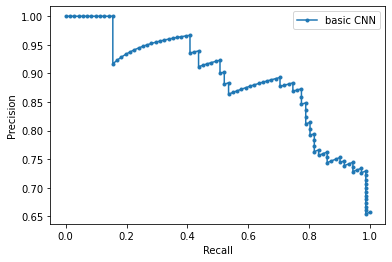

In [44]:
ypred = model.predict(xtest)

precision, recall, _ = precision_recall_curve(ytest, ypred)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision, marker='.', label='basic CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()